# Annex 01 - Data

In [ ]:
import datetime as dt

import contextily as cx
import numpy as np
import osmnx as ox
import pandas as pd
import pooch
import rasterio as rio
import seaborn as sns
import swisstopopy as stp
import zenodo_client
from meteora import utils
from meteora.clients import AWELClient, MeteoSwissClient, NetatmoClient
from rasterio import mask, plot

In [ ]:
# region data
region = "Zurich"
crs = "epsg:2056"  # projected CRS in meters
buffer_dist = 2000  # in meters

# Netatmo auth
client_id = "67f78032dc5e2ec4ce0cab32"
client_secret = "H7eZ60QOXydhCrvdZeJ3gj6Hz"

# for heatwave detection
year = 2022
start_month = 6
end_month = 8
heatwave_t_threshold = 25
heatwave_n_consecutive_days = 3
station_agg_func = "mean"
inter_station_agg_func = "max"

# target temperature data
target_hour = 21  # 9 PM

# land use/land cover (LULC) survey
# sls_column = "LU18_4"
lulc_url = (
    "https://access.yareta.unige.ch/access/metadata/"
    "6ab4b715-904f-4cb9-961c-6a25b4c1116b/data/8744b6b3-777e-498b-b4ae-d082fd0ebb30/"
    "download"
)

# output files
dst_study_area_filepath = "data/study-area.gpkg"
dst_stations_filepath = "data/stations.gpkg"
dst_netatmo_cws_filepath = "data/netatmo-cws.gpkg"
dst_ts_df_filepath = "data/heatwaves-2022.csv"
dst_lulc_filepath = "data/lulc.tif"
dst_buildings_gdf_filepath = "data/buildings.gpkg"
dst_dem_filepath = "data/dem.tif"
dst_tree_canopy_filepath = "data/tree-canopy.tif"

In [ ]:
# buffer around the region so that we can compute focal features
region_buffer_gser = ox.geocode_to_gdf(region).to_crs(crs).buffer(buffer_dist)

In [ ]:
# save study area to a file
region_buffer_gser.to_file(dst_study_area_filepath)

## Meteoroloical data

### Meteorological stations

In [ ]:
# get meteorological stations for the (non-buffered) region
client_dict = {
    "AWEL": AWELClient(region),
    "MeteoSwiss": MeteoSwissClient(region),
}
# rename elevation column to have a common label
ELEV_COL_RENAME_DICT = {
    "masl": "elevation",  # for AWEL
    "station_height_masl": "elevation",  # for MeteoSwiss
}
stations_gdf = pd.concat(
    [
        client.stations_gdf.to_crs(crs)
        .rename(columns=ELEV_COL_RENAME_DICT)[["elevation", "geometry"]]
        .assign(source=source)
        for source, client in client_dict.items()
    ]
)

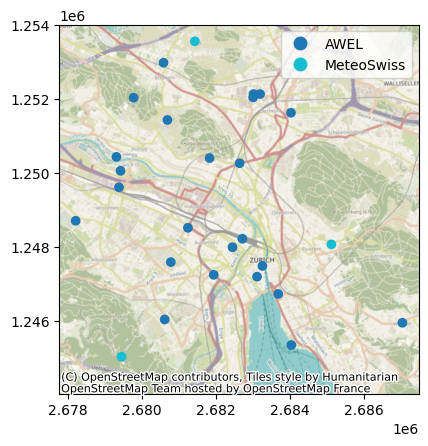

In [ ]:
# plot them on a map
ax = stations_gdf.plot("source", legend=True)
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
# save stations to file
stations_gdf.to_file(dst_stations_filepath)

### Citizen weather stations

In [ ]:
netatmo_cws_gdf = (
    NetatmoClient(region, client_id, client_secret)
    .stations_gdf.rename(columns={"altitude": "elevation"})
    .to_crs(stations_gdf.crs)
)

100%|████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.45it/s]


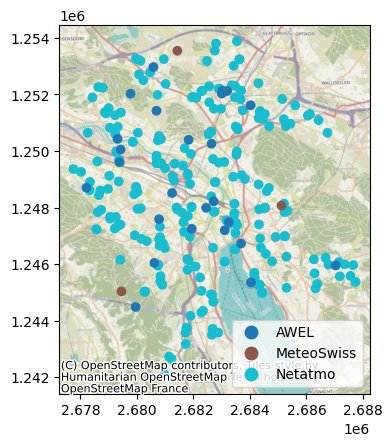

In [ ]:
# plot them on a map
ax = pd.concat([netatmo_cws_gdf.assign(source="Netatmo"), stations_gdf]).plot(
    "source", legend=True
)
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
netatmo_cws_gdf.to_file(dst_netatmo_cws_filepath)

### Temperature data

We will get the air temperature data [for all the heatwaves](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html) of the target year.

In [ ]:
# get the JJA time series of temperature measurements, convert it to wide format, drop
# stations with no data and resample to hourly mean
ts_df = (
    utils.long_to_wide(
        pd.concat(
            [
                client.get_ts_df(
                    "temperature",
                    dt.date(year, start_month, 1),
                    # get latest moment of the latest day of the month
                    # ACHTUNG: this won't work if `end_month` is 12 (see commented code
                    # below)
                    dt.datetime.combine(
                        dt.date(year, end_month + 1, 1) - dt.timedelta(days=1),
                        dt.time.max,
                    ),
                )
                for client in client_dict.values()
            ]
        )
    )
    .dropna(how="all", axis="columns")
    .resample("h")
    .mean()
)
ts_df.head()

station_id,530,534,2651,2652,2653,2655,2656,2657,2659,2679,...,2683,2688,2689,2695,2696,2697,2698,2810,REH,SMA
time,,,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,14.025000,15.190000,13.791667,15.360000,13.258333,15.058333,11.491667,14.486667,15.248333,14.216667,...,14.155000,15.292000,15.605000,14.961667,14.378000,12.220000,14.871667,14.343333,11.683333,13.650000
2022-06-01 01:00:00,13.401667,14.543333,13.083333,14.755000,11.865000,14.628333,11.410000,13.923333,14.600000,13.660000,...,13.701667,14.662000,14.821667,14.670000,13.480000,11.753333,14.408333,13.564000,11.250000,12.566667
2022-06-01 02:00:00,13.008333,14.025000,12.868333,14.256667,11.078333,14.113333,11.531667,13.758333,14.031667,13.051667,...,12.888333,14.518333,14.406667,14.368000,13.301667,11.708000,13.926667,13.328333,11.766667,12.316667
2022-06-01 03:00:00,12.896667,14.191667,12.433333,14.394000,11.395000,13.755000,11.598333,12.890000,14.010000,13.648333,...,12.618333,14.260000,14.398333,13.800000,12.957500,11.812000,13.928333,13.276667,11.033333,12.200000
2022-06-01 04:00:00,13.034000,14.434000,12.593333,14.753333,12.128333,13.562500,11.658333,12.980000,14.375000,14.088333,...,13.028333,13.938000,14.561667,13.685000,13.152000,12.395000,14.081667,13.483333,11.083333,12.550000


In [ ]:
# get only heatwave data
heatwave_ts_df = utils.get_heatwave_ts_df(
    ts_df,
    heatwave_t_threshold=heatwave_t_threshold,
    heatwave_n_consecutive_days=heatwave_n_consecutive_days,
    station_agg_func=station_agg_func,
    inter_station_agg_func=inter_station_agg_func,
)
heatwave_ts_df.head()

station_id                                       530        534       2651  \
heatwave              time                                                   
2022-06-16/2022-06-20 2022-06-16 00:00:00  20.741667  23.083333  21.096667   
                      2022-06-16 01:00:00  20.438333  22.448333  20.618333   
                      2022-06-16 02:00:00  19.170000  21.163333  19.273333   
                      2022-06-16 03:00:00  18.256667  19.405000  17.851667   
                      2022-06-16 04:00:00  18.696667  19.703333  18.443333   

station_id                                      2652       2653       2655  \
heatwave              time                                                   
2022-06-16/2022-06-20 2022-06-16 00:00:00  23.718000  20.600000  22.948333   
                      2022-06-16 01:00:00  22.981667  19.800000  22.215000   
                      2022-06-16 02:00:00  21.064000  19.331667  20.286667   
                      2022-06-16 03:00:00  19.430000  17.592000  18.858333   
                      2022-06-16 04:00:00  19.780000  17.575000  19.425000   

station_id                                      2656       2657       2659  \
heatwave              time                                                   
2022-06-16/2022-06-20 2022-06-16 00:00:00  20.684000  21.472000  22.838333   
                      2022-06-16 01:00:00  20.358333  21.364000  22.166667   
                      2022-06-16 02:00:00  17.365000  19.534000  20.880000   
                      2022-06-16 03:00:00  15.910000  18.286667  19.208333   
                      2022-06-16 04:00:00  15.873333  18.564000  19.476667   

station_id                                      2679  ...       2683  \
heatwave              time                            ...              
2022-06-16/2022-06-20 2022-06-16 00:00:00  22.233333  ...  21.430000   
                      2022-06-16 01:00:00  21.885000  ...  21.043333   
                      2022-06-16 02:00:00  20.063333  ...  20.153333   
                      2022-06-16 03:00:00  18.556667  ...  18.153333   
                      2022-06-16 04:00:00  18.928333  ...  18.706667   

station_id                                      2688       2689       2695  \
heatwave              time                                                   
2022-06-16/2022-06-20 2022-06-16 00:00:00  22.205000  23.291667  22.943333   
                      2022-06-16 01:00:00  22.043333  22.601667  22.828333   
                      2022-06-16 02:00:00  20.110000  20.986667  20.458333   
                      2022-06-16 03:00:00  18.973333  19.828333  19.043333   
                      2022-06-16 04:00:00  19.428333  20.243333  19.418333   

station_id                                      2696       2697       2698  \
heatwave              time                                                   
2022-06-16/2022-06-20 2022-06-16 00:00:00  21.340000  20.306000  23.263333   
                      2022-06-16 01:00:00  21.432000  20.006667  22.358333   
                      2022-06-16 02:00:00  19.368333  18.266000  20.426667   
                      2022-06-16 03:00:00  18.125000  17.180000  19.428333   
                      2022-06-16 04:00:00  18.416667  17.361667  19.585000   

station_id                                      2810        REH        SMA  
heatwave              time                                                  
2022-06-16/2022-06-20 2022-06-16 00:00:00  20.888333  18.366667  21.433333  
                      2022-06-16 01:00:00  20.355000  17.683333  20.383333  
                      2022-06-16 02:00:00  19.641667  18.416667  19.033333  
                      2022-06-16 03:00:00  18.095000  17.333333  17.816667  
                      2022-06-16 04:00:00  17.935000  17.783333  17.633333  

[5 rows x 22 columns]

<Axes: xlabel='hour', ylabel='temperature'>

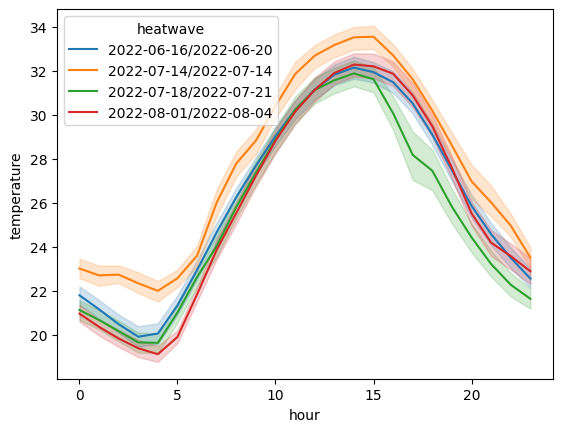

In [ ]:
# plot hourly time series
plot_ts_df = heatwave_ts_df.stack().rename("temperature").reset_index()
sns.lineplot(
    data=plot_ts_df.assign(**{"hour": plot_ts_df["time"].dt.hour}),
    x="hour",
    y="temperature",
    hue="heatwave",
)

In [ ]:
# save temperature time series to file (only target hour)
heatwave_ts_df.droplevel("heatwave")[
    heatwave_ts_df.index.get_level_values("time").hour == target_hour
].to_csv(dst_ts_df_filepath)

## Land use data

Version of the [Swiss land use statistics](https://www.bfs.admin.ch/bfs/en/home/dienstleistungen/geostat/geodaten-bundesstatistik/boden-nutzung-bedeckung-eignung/arealstatistik-schweiz.html) downscaled to 25 m resolution by <cite data-cite="giuliani2022downscaling"/>.

In [ ]:
# get Swiss LULC data and clip it to the target (buffered) region only
lulc_filepath = pooch.retrieve(lulc_url, known_hash=None)
with rio.open(lulc_filepath) as src:
    dst_img, dst_transform = mask.mask(src, [region_buffer_gser.iloc[0]], crop=True)
    dst_meta = src.meta.copy()

# replace "nodata" with 0, the "nodata" value in the Swiss land use statistics
dst_nodata = 0  # src.nodata
dst_meta.update(
    {
        "driver": "GTiff",
        "nodata": dst_nodata,
        "height": dst_img.shape[1],
        "width": dst_img.shape[2],
        "transform": dst_transform,
    }
)

# reclassify to 4 main domains only - ACHTUNG: ugly hardcoded procedure
dst_img = np.digitize(
    dst_img, [1, 3, 15, 24, 31, 37, 41, 42, 45, 50, 57, 58, 61, 62, 64, 69, 72]
)

dst_img = np.where(dst_img < 17, dst_img, dst_nodata)
with rio.open(dst_lulc_filepath, "w", **dst_meta) as dst:
    dst.write(dst_img)

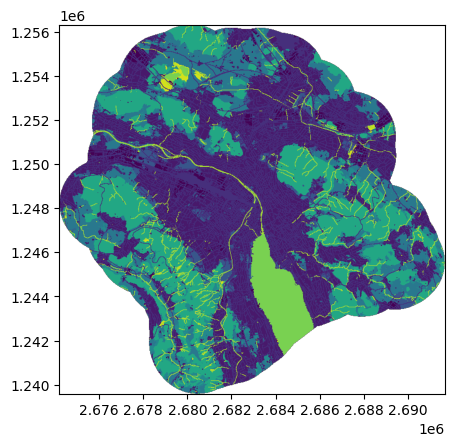

In [ ]:
# plot the region data from the target LULC survey
with rio.open(dst_lulc_filepath) as src:
    plot.show(src)

## Buildings with heights

In [ ]:
# get building footprints with heights (from Swisstopo) for the (buffered) region
building_gdf = stp.get_bldg_gdf(region_buffer_gser)
# compute area and add it as a column (note that building_gdf is already projected)
building_gdf = building_gdf.assign(**{"area": building_gdf.area})
# drop the "element" index level (index by osmid only)
building_gdf = building_gdf.droplevel("element")

  0%|                                                        | 0/229 [00:00<?, ?it/s]/home/martibosch/libraries/focalpy/.pixi/envs/user-guide/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|██████████████████████████████████████████████| 229/229 [02:38<00:00,  1.44it/s]


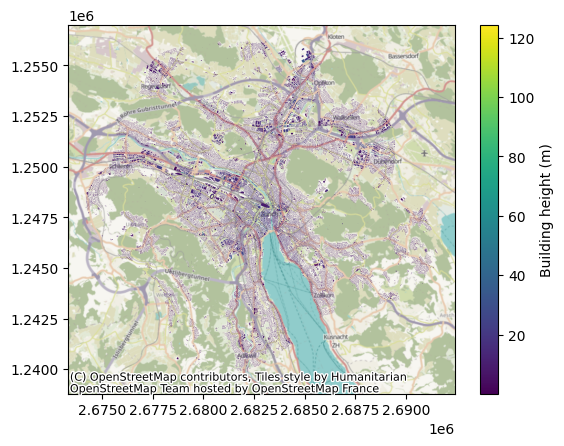

In [ ]:
# plot buildings with heights
ax = building_gdf.plot(
    column="height",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Building height (m)"},
)
cx.add_basemap(ax, crs=building_gdf.crs)

In [ ]:
# save to a file
building_gdf.to_file(dst_buildings_gdf_filepath)

## Digital Elevation model

In [ ]:
# get DEM raster (from Swisstopo) for the (buffered) region and save to a file
stp.get_dem_raster(region_buffer_gser, dst_dem_filepath, alti3d_res=2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 5158.60it/s]


In [ ]:
# # plot DEM raster
# fig, ax = plt.subplots()
# with rio.open(dst_dem_filepath) as src:
#     retted = plot.show(src, ax=ax)
# fig.colorbar(retted.get_images()[0], ax=ax)

## Tree canopy cover

In [ ]:
# get tree canopy cover raster (from Swisstopo) for the (buffered) region and save to a
# file
stp.get_tree_canopy_raster(
    region_buffer_gser, dst_tree_canopy_filepath, pooch_retrieve_kwargs={"path": "las"}
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 50762.80it/s]


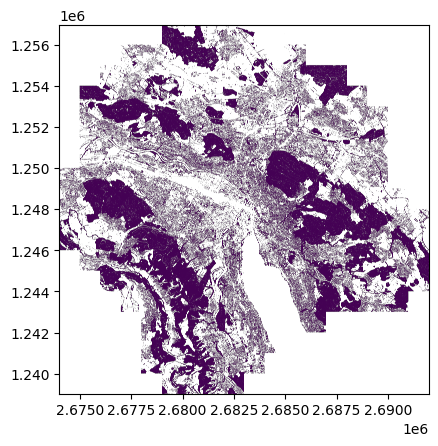

In [ ]:
# plot tree canopy map
with rio.open(dst_tree_canopy_filepath) as src:
    retted = plot.show(src)

## Upload to zenodo

In [ ]:
# first upload
# define the metadata that will be used on initial upload
# data = zenodo_client.Metadata(
#     title="focalpy user guide data",
#     upload_type="dataset",
#     description="Data used for the focalpy user guide",
#     creators=[
#         zenodo_client.Creator(
#             name="Bosch, Martí",
#             affiliation="University of Bern",
#             orcid="0000-0001-8735-9144",
#         ),
#     ],
# )
# res = zenodo_client.ensure_zenodo(
#     # this is a unique key you pick that will be used to store the numeric deposition
#     # ID on your local system's cache
#     key="focalpy",
#     data=data,
#     paths=[
#         dst_study_area_filepath,
#         dst_stations_filepath,
#         dst_ts_df_filepath,
#         dst_lulc_filepath,
#         dst_buildings_gdf_filepath,
#         dst_dem_filepath,
#         dst_tree_canopy_filepath,
#     ],
#     # sandbox=True,  # remove this when you're ready to upload to real Zenodo
# )
# update existing repository
DEP_ID = "17621306"
res = zenodo_client.update_zenodo(
    DEP_ID,
    # add the list of files to update
    [dst_netatmo_cws_filepath],
)

# show the links to the generated zenodo repository
links = res.json()["links"]
print(f"URL: {links['html']}\nDOI: {links['doi']}")

URL: https://zenodo.org/records/17702498
DOI: https://doi.org/10.5281/zenodo.17702498
